In [2]:
import pandas as pd
import numpy as np

# Load data
df = pd.read_csv('/content/AirQualityUCI.csv', sep=';', decimal=',')  # Note: European decimal format
df = df.iloc[:, :-2]  # Drop last two empty columns if present

# Replace missing values (-200) with NaN
df.replace(-200, np.nan, inplace=True)

# Combine Date and Time into datetime
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H.%M.%S')
df.set_index('Datetime', inplace=True)
df.drop(['Date', 'Time'], axis=1, inplace=True)

# Drop high-null column: NMHC(GT) (~91% missing)
df.drop('NMHC(GT)', axis=1, inplace=True)

# Explore before cleaning
print("Shape before cleaning:", df.shape)
print(df.head())
print(df.describe())
print("Null values per column before interpolation:\n", df.isnull().sum())

Shape before cleaning: (9471, 12)
                     CO(GT)  PT08.S1(CO)  C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  \
Datetime                                                                     
2004-03-10 18:00:00     2.6       1360.0      11.9         1046.0    166.0   
2004-03-10 19:00:00     2.0       1292.0       9.4          955.0    103.0   
2004-03-10 20:00:00     2.2       1402.0       9.0          939.0    131.0   
2004-03-10 21:00:00     2.2       1376.0       9.2          948.0    172.0   
2004-03-10 22:00:00     1.6       1272.0       6.5          836.0    131.0   

                     PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T  \
Datetime                                                                      
2004-03-10 18:00:00        1056.0    113.0        1692.0       1268.0  13.6   
2004-03-10 19:00:00        1174.0     92.0        1559.0        972.0  13.3   
2004-03-10 20:00:00        1140.0    114.0        1555.0       1074.0  11.9   
2004-03-10 21:00:00     

In [3]:
import pandas as pd
import numpy as np


# Load data
df = pd.read_csv('AirQualityUCI.csv', sep=';', decimal=',')  # Note: European decimal format
df = df.iloc[:, :-2]  # Drop last two empty columns if present

# Replace missing values (-200) with NaN
df.replace(-200, np.nan, inplace=True)

# Combine Date and Time into datetime, handling potential parsing errors
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H.%M.%S', errors='coerce')
df.set_index('Datetime', inplace=True)
df.drop(['Date', 'Time'], axis=1, inplace=True)

# Drop rows where Datetime index failed to parse (if any)
df = df.dropna(how='all')  # Drop rows where all values are NaN (including index parse failures)

# Check for duplicate or NaN indices and handle them
if df.index.duplicated().any():
    df = df[~df.index.duplicated(keep='first')]  # Keep first occurrence, drop duplicates
if df.index.isnull().any():
    raise ValueError("NaNs found in index after parsing. Check Date/Time data.")

# Drop high-null column: NMHC(GT) (~91% missing)
df.drop('NMHC(GT)', axis=1, inplace=True)

# Interpolate missing values using linear method (safer initial step)
df.interpolate(method='linear', inplace=True)

# Fill any remaining edge nulls with forward/backward fill
df.ffill(inplace=True)  # Forward fill
df.bfill(inplace=True)  # Backward fill (in case of leading nulls)

# Drop any rows that still have nulls (should be none or very few)
df.dropna(inplace=True)

# Verify no nulls remain
print("Null values per column after handling:\n", df.isnull().sum())
print("Shape after cleaning:", df.shape)  # Check how many rows remain (~9357 expected, minor loss if any)

# Select target and features (exclude dropped NMHC(GT))
features = ['PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)',
            'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']
target = 'CO(GT)'
data = df[features + [target]]



Null values per column after handling:
 CO(GT)           0
PT08.S1(CO)      0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
dtype: int64
Shape after cleaning: (9326, 12)


In [4]:
#Scaling Data
from sklearn.preprocessing import MinMaxScaler

# Scale data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(df[features])
y_scaled = scaler_y.fit_transform(df[[target]])

In [5]:
# Create a time series sequence
seq_length = 1
X_seq, y_seq = [], []
for i in range(len(X_scaled) - seq_length):
    X_seq.append(X_scaled[i:i + seq_length])
    y_seq.append(y_scaled[i + seq_length])
X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

In [7]:
# Split into train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}, Test data shape: {X_test.shape}")

Training data shape: (7460, 1, 11), Test data shape: (1865, 1, 11)


#MODEL ARCHITECTURE(LSTM MODEL )


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.callbacks import EarlyStopping

# Build model
model = Sequential([
    LSTM(64, activation='tanh', return_sequences=False, input_shape=(seq_length, len(features))),
    Dropout(0.2),  # Prevent overfitting
    Dense(32, activation='relu'),
    Dense(1)  # Regression output for AQI
])

# Compile
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=MeanSquaredError(),
              metrics=[MeanAbsoluteError()])

# Train with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, callbacks=[early_stopping], verbose=1)

# Evaluate
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test MAE: {test_mae:.4f}")

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0109 - mean_absolute_error: 0.0748 - val_loss: 0.0057 - val_mean_absolute_error: 0.0527
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0059 - mean_absolute_error: 0.0549 - val_loss: 0.0055 - val_mean_absolute_error: 0.0522
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0053 - mean_absolute_error: 0.0524 - val_loss: 0.0053 - val_mean_absolute_error: 0.0512
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0056 - mean_absolute_error: 0.0533 - val_loss: 0.0053 - val_mean_absolute_error: 0.0498
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0053 - mean_absolute_error: 0.0518 - val_loss: 0.0053 - val_mean_absolute_error: 0.0497
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0052 - mean_absolute_error: 0.0511 - val_loss: 0.0052 - val_mean_absolute_error: 0.0499
Epoch 7/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0052 - mean_absolute_error: 0.0509 - val_loss: 0.

In [9]:
!pip install keras_tuner -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.8 MB/s eta 0:00:00


In [10]:
#Hyperparameter Tuning
import keras_tuner as kt

def build_model(hp):
    model = Sequential([
        LSTM(hp.Int('lstm_units', min_value=32, max_value=128, step=32), activation='tanh', return_sequences=False, input_shape=(seq_length, len(features))),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
                  loss=MeanSquaredError(),
                  metrics=[MeanAbsoluteError()])
    return model

tuner = kt.RandomSearch(build_model, objective='val_loss', max_trials=5, executions_per_trial=2)
tuner.search(X_train, y_train, epochs=30, validation_split=0.2)

# Get best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best LSTM units: {best_hps.get('lstm_units')}, Best learning rate: {best_hps.get('learning_rate')}")

# Build and train best model
best_model = tuner.hypermodel.build(best_hps)
best_model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, callbacks=[early_stopping])

Trial 5 Complete [00h 01m 06s]
val_loss: 0.004903481109067798

Best val_loss So Far: 0.004760707262903452
Total elapsed time: 00h 04m 46s
Best LSTM units: 64, Best learning rate: 0.0015793652406955135
Epoch 1/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0092 - mean_absolute_error: 0.0709 - val_loss: 0.0058 - val_mean_absolute_error: 0.0533
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0058 - mean_absolute_error: 0.0543 - val_loss: 0.0053 - val_mean_absolute_error: 0.0525
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0054 - mean_absolute_error: 0.0522 - val_loss: 0.0057 - val_mean_absolute_error: 0.0511
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0053 - mean_absolute_error: 0.0522 - val_loss: 0.0052 - val_mean_absolute_error: 0.0507
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0054 - mean_absolute_error: 0.0509 - val_loss: 0.0052 - val_mean_absolute_error: 0.0501
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/st

In [11]:
#Fine Tuning
# Reduce learning rate for fine-tuning
fine_tune_optimizer = Adam(learning_rate=best_hps.get('learning_rate') / 10)  # Lower LR
best_model.compile(optimizer=fine_tune_optimizer, loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

# Fine-tune on validation data (or a small new dataset)
fine_tune_history = best_model.fit(X_test, y_test, epochs=20, batch_size=64, verbose=1)  # Smaller epochs, larger batch

# Re-evaluate
fine_test_loss, fine_test_mae = best_model.evaluate(X_test, y_test)
print(f"Fine-tuned Test MAE: {fine_test_mae:.4f}")

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0047 - mean_absolute_error: 0.0482
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0047 - mean_absolute_error: 0.0491
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0044 - mean_absolute_error: 0.0462
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0046 - mean_absolute_error: 0.0473
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0044 - mean_absolute_error: 0.0467
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0045 - mean_absolute_error: 0.0476
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0045 - mean_absolute_error: 0.0478
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0047 - mean_absolute_error: 0.0480
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0047 - mean_absolute_error: 0.0480
Epoch 10/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0042 - mean_absolute_error: 0.0452
Epoch 11/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/ste

In [12]:
import numpy as np
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
import matplotlib.pyplot as plt
import seaborn as sns

# Load and preprocess training data (mimicking AIRQUALITY1_(2).ipynb)
def load_training_data(file_path='AirQualityUCI.csv'):
    df = pd.read_csv(file_path, sep=';', decimal=',')
    df = df.iloc[:, :-2]  # Drop last two empty columns
    df.replace(-200, np.nan, inplace=True)
    df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H.%M.%S', errors='coerce')
    df.set_index('Datetime', inplace=True)
    df.drop(['Date', 'Time', 'NMHC(GT)'], axis=1, inplace=True)
    df.interpolate(method='linear', inplace=True)
    df.ffill(inplace=True)
    df.bfill(inplace=True)
    df.dropna(inplace=True)
    return df

# Load training data
try:
    training_data = load_training_data()
except FileNotFoundError:
    print("Error: AirQualityUCI.csv not found. Please upload the file to Colab.")
    training_data = None

# Inject JavaScript for Enter/Tab navigation
js_code = """
<script>
document.addEventListener('DOMContentLoaded', function() {
    const inputs = document.querySelectorAll('input[type="number"]');
    inputs.forEach((input, index) => {
        input.addEventListener('keydown', (event) => {
            if (event.key === 'Enter' || event.key === 'Tab') {
                event.preventDefault();
                const nextIndex = (index + 1) % inputs.length;
                inputs[nextIndex].focus();
            }
        });
    });
});
</script>
"""
display(HTML(js_code))

def predict_aqi(input_sequence, seq_length=1, features=None):
    """
    Calculate AQI based on the average of 11 input features across the sequence.
    """
    if features is None:
        features = ['PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)',
                    'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']

    input_sequence = np.array(input_sequence, dtype=float)
    if input_sequence.shape != (seq_length, len(features)):
        raise ValueError(f"Expected input shape ({seq_length}, {len(features)}), got {input_sequence.shape}")

    avg_value = np.mean(input_sequence)
    if avg_value <= 50:
        category = "Good"
        message = "The air quality is Good - Enjoy outdoor activities!"
    elif avg_value <= 100:
        category = "Moderate"
        message = "The air quality is Moderate - Acceptable, but some pollutants may affect sensitive groups."
    elif avg_value <= 200:
        category = "Poor"
        message = "The air quality is Poor - Unhealthy for sensitive groups; reduce outdoor activities."
    else:
        category = "Hazardous"
        message = "The air quality is Hazardous - Health warnings; everyone should avoid outdoor activities."

    return avg_value, category, message

# Plotting functions
def plot_time_series(training_data, user_data=None, seq_length=1, features=None):
    if training_data is None:
        print("No training data available for plotting.")
        return

    plt.figure(figsize=(12, 6))
    pollutants = ['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']

    # Aggregate training data to daily averages
    daily_data = training_data[pollutants].resample('D').mean()

    # Plot training data
    for pollutant in pollutants:
        plt.plot(daily_data.index, daily_data[pollutant], label=f'Training {pollutant}', alpha=0.7)

    # Plot user input data if provided
    if user_data is not None and features is not None:
        user_data = np.array(user_data)
        pollutant_indices = [features.index(col) for col in pollutants if col in features]
        if pollutant_indices:
            user_avg = np.mean(user_data[:, pollutant_indices], axis=0)
            # Assume user data is for the last day in the training data
            last_date = daily_data.index[-1]
            for i, idx in enumerate(pollutant_indices):
                plt.scatter([last_date], [user_avg[i]], label=f'User {pollutants[i]}', marker='o', s=100)

    plt.title('Daily Average Pollutant Concentrations (Training vs. User Input)')
    plt.xlabel('Date')
    plt.ylabel('Concentration')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_box_plot(training_data, user_data=None, seq_length=1, features=None):
    if training_data is None:
        print("No training data available for plotting.")
        return

    plt.figure(figsize=(10, 6))
    pollutants = ['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']
    data_to_plot = [training_data[pollutant].dropna() for pollutant in pollutants]

    # Plot box plots for training data
    plt.boxplot(data_to_plot, labels=pollutants, patch_artist=True, boxprops=dict(facecolor='lightblue'))

    # Add user input averages as points
    if user_data is not None and features is not None:
        user_data = np.array(user_data)
        pollutant_indices = [features.index(col) for col in pollutants if col in features]
        if pollutant_indices:
            user_avg = np.mean(user_data[:, pollutant_indices], axis=0)
            for i, idx in enumerate(pollutant_indices):
                plt.scatter(i + 1, user_avg[i], color='red', marker='o', s=100, label='User Input Average' if i == 0 else None)

    plt.title('Pollutant Distributions (Training vs. User Input)')
    plt.ylabel('Concentration')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_correlation_heatmap(training_data):
    if training_data is None:
        print("No training data available for plotting.")
        return

    plt.figure(figsize=(10, 8))
    correlation_matrix = training_data.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    plt.title('Correlation Heatmap of Training Data Features')
    plt.tight_layout()
    plt.show()

# Widget for interactive input and plotting
def create_aqi_prediction_widget(default_seq_length=24):
    features = ['PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)',
                'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']
    num_features = len(features)

    seq_length_widget = widgets.IntText(
        value=default_seq_length,
        description='Sequence Length:',
        style={'description_width': 'initial'}
    )
    input_fields = []
    input_container = widgets.VBox()
    output = widgets.Output()

    # Plotting buttons
    time_series_button = widgets.Button(
        description='Plot Time Series',
        button_style='info',
        tooltip='Plot training and user data time series'
    )
    box_plot_button = widgets.Button(
        description='Plot Box Plot',
        button_style='info',
        tooltip='Plot training and user data distributions'
    )
    heatmap_button = widgets.Button(
        description='Plot Correlation Heatmap',
        button_style='info',
        tooltip='Plot training data correlation heatmap'
    )
    predict_button = widgets.Button(
        description='Predict AQI',
        button_style='primary',
        tooltip='Click to predict AQI'
    )

    def update_input_fields(change):
        input_fields.clear()
        input_container.children = []
        seq_length = seq_length_widget.value
        for i in range(seq_length):
            timestep_inputs = []
            for feature in features:
                field = widgets.FloatText(
                    value=0.0,
                    description=f"{feature} (t{i+1}):",
                    style={'description_width': 'initial'},
                    layout={'width': '400px'}
                )
                timestep_inputs.append(field)
            input_fields.append(timestep_inputs)
            input_container.children = [widgets.VBox([field for field in timestep_inputs])] + list(input_container.children)

    seq_length_widget.observe(update_input_fields, names='value')
    update_input_fields(None)

    def on_predict_button_clicked(b):
        with output:
            clear_output()
            try:
                seq_length = seq_length_widget.value
                user_input_sequence = []
                for timestep_inputs in input_fields:
                    values = [field.value for field in timestep_inputs]
                    if len(values) != num_features:
                        print(f"Error: Expected {num_features} values per timestep, got {len(values)}")
                        return
                    user_input_sequence.append(values)

                user_input_sequence = np.array(user_input_sequence)
                avg_value, category, message = predict_aqi(
                    user_input_sequence, seq_length=seq_length, features=features
                )

                print(f"Average Value Across Features: {avg_value:.2f}")
                print(f"Predicted AQI Category: {category}")
                print(message)

            except ValueError as e:
                print(f"Input Error: {e}")
            except Exception as e:
                print(f"An unexpected error occurred: {e}")

    def on_time_series_button_clicked(b):
        with output:
            clear_output()
            try:
                seq_length = seq_length_widget.value
                user_input_sequence = []
                for timestep_inputs in input_fields:
                    values = [field.value for field in timestep_inputs]
                    if len(values) != num_features:
                        print(f"Error: Expected {num_features} values per timestep, got {len(values)}")
                        return
                    user_input_sequence.append(values)

                plot_time_series(training_data, user_data=user_input_sequence, seq_length=seq_length, features=features)
            except Exception as e:
                print(f"Plotting Error: {e}")

    def on_box_plot_button_clicked(b):
        with output:
            clear_output()
            try:
                seq_length = seq_length_widget.value
                user_input_sequence = []
                for timestep_inputs in input_fields:
                    values = [field.value for field in timestep_inputs]
                    if len(values) != num_features:
                        print(f"Error: Expected {num_features} values per timestep, got {len(values)}")
                        return
                    user_input_sequence.append(values)

                plot_box_plot(training_data, user_data=user_input_sequence, seq_length=seq_length, features=features)
            except Exception as e:
                print(f"Plotting Error: {e}")

    def on_heatmap_button_clicked(b):
        with output:
            clear_output()
            try:
                plot_correlation_heatmap(training_data)
            except Exception as e:
                print(f"Plotting Error: {e}")

    predict_button.on_click(on_predict_button_clicked)
    time_series_button.on_click(on_time_series_button_clicked)
    box_plot_button.on_click(on_box_plot_button_clicked)
    heatmap_button.on_click(on_heatmap_button_clicked)

    display(widgets.VBox([seq_length_widget, input_container,
                          widgets.HBox([predict_button, time_series_button, box_plot_button, heatmap_button]),
                          output]))

# Example usage
if __name__ == "__main__":
    create_aqi_prediction_widget(default_seq_length=24)

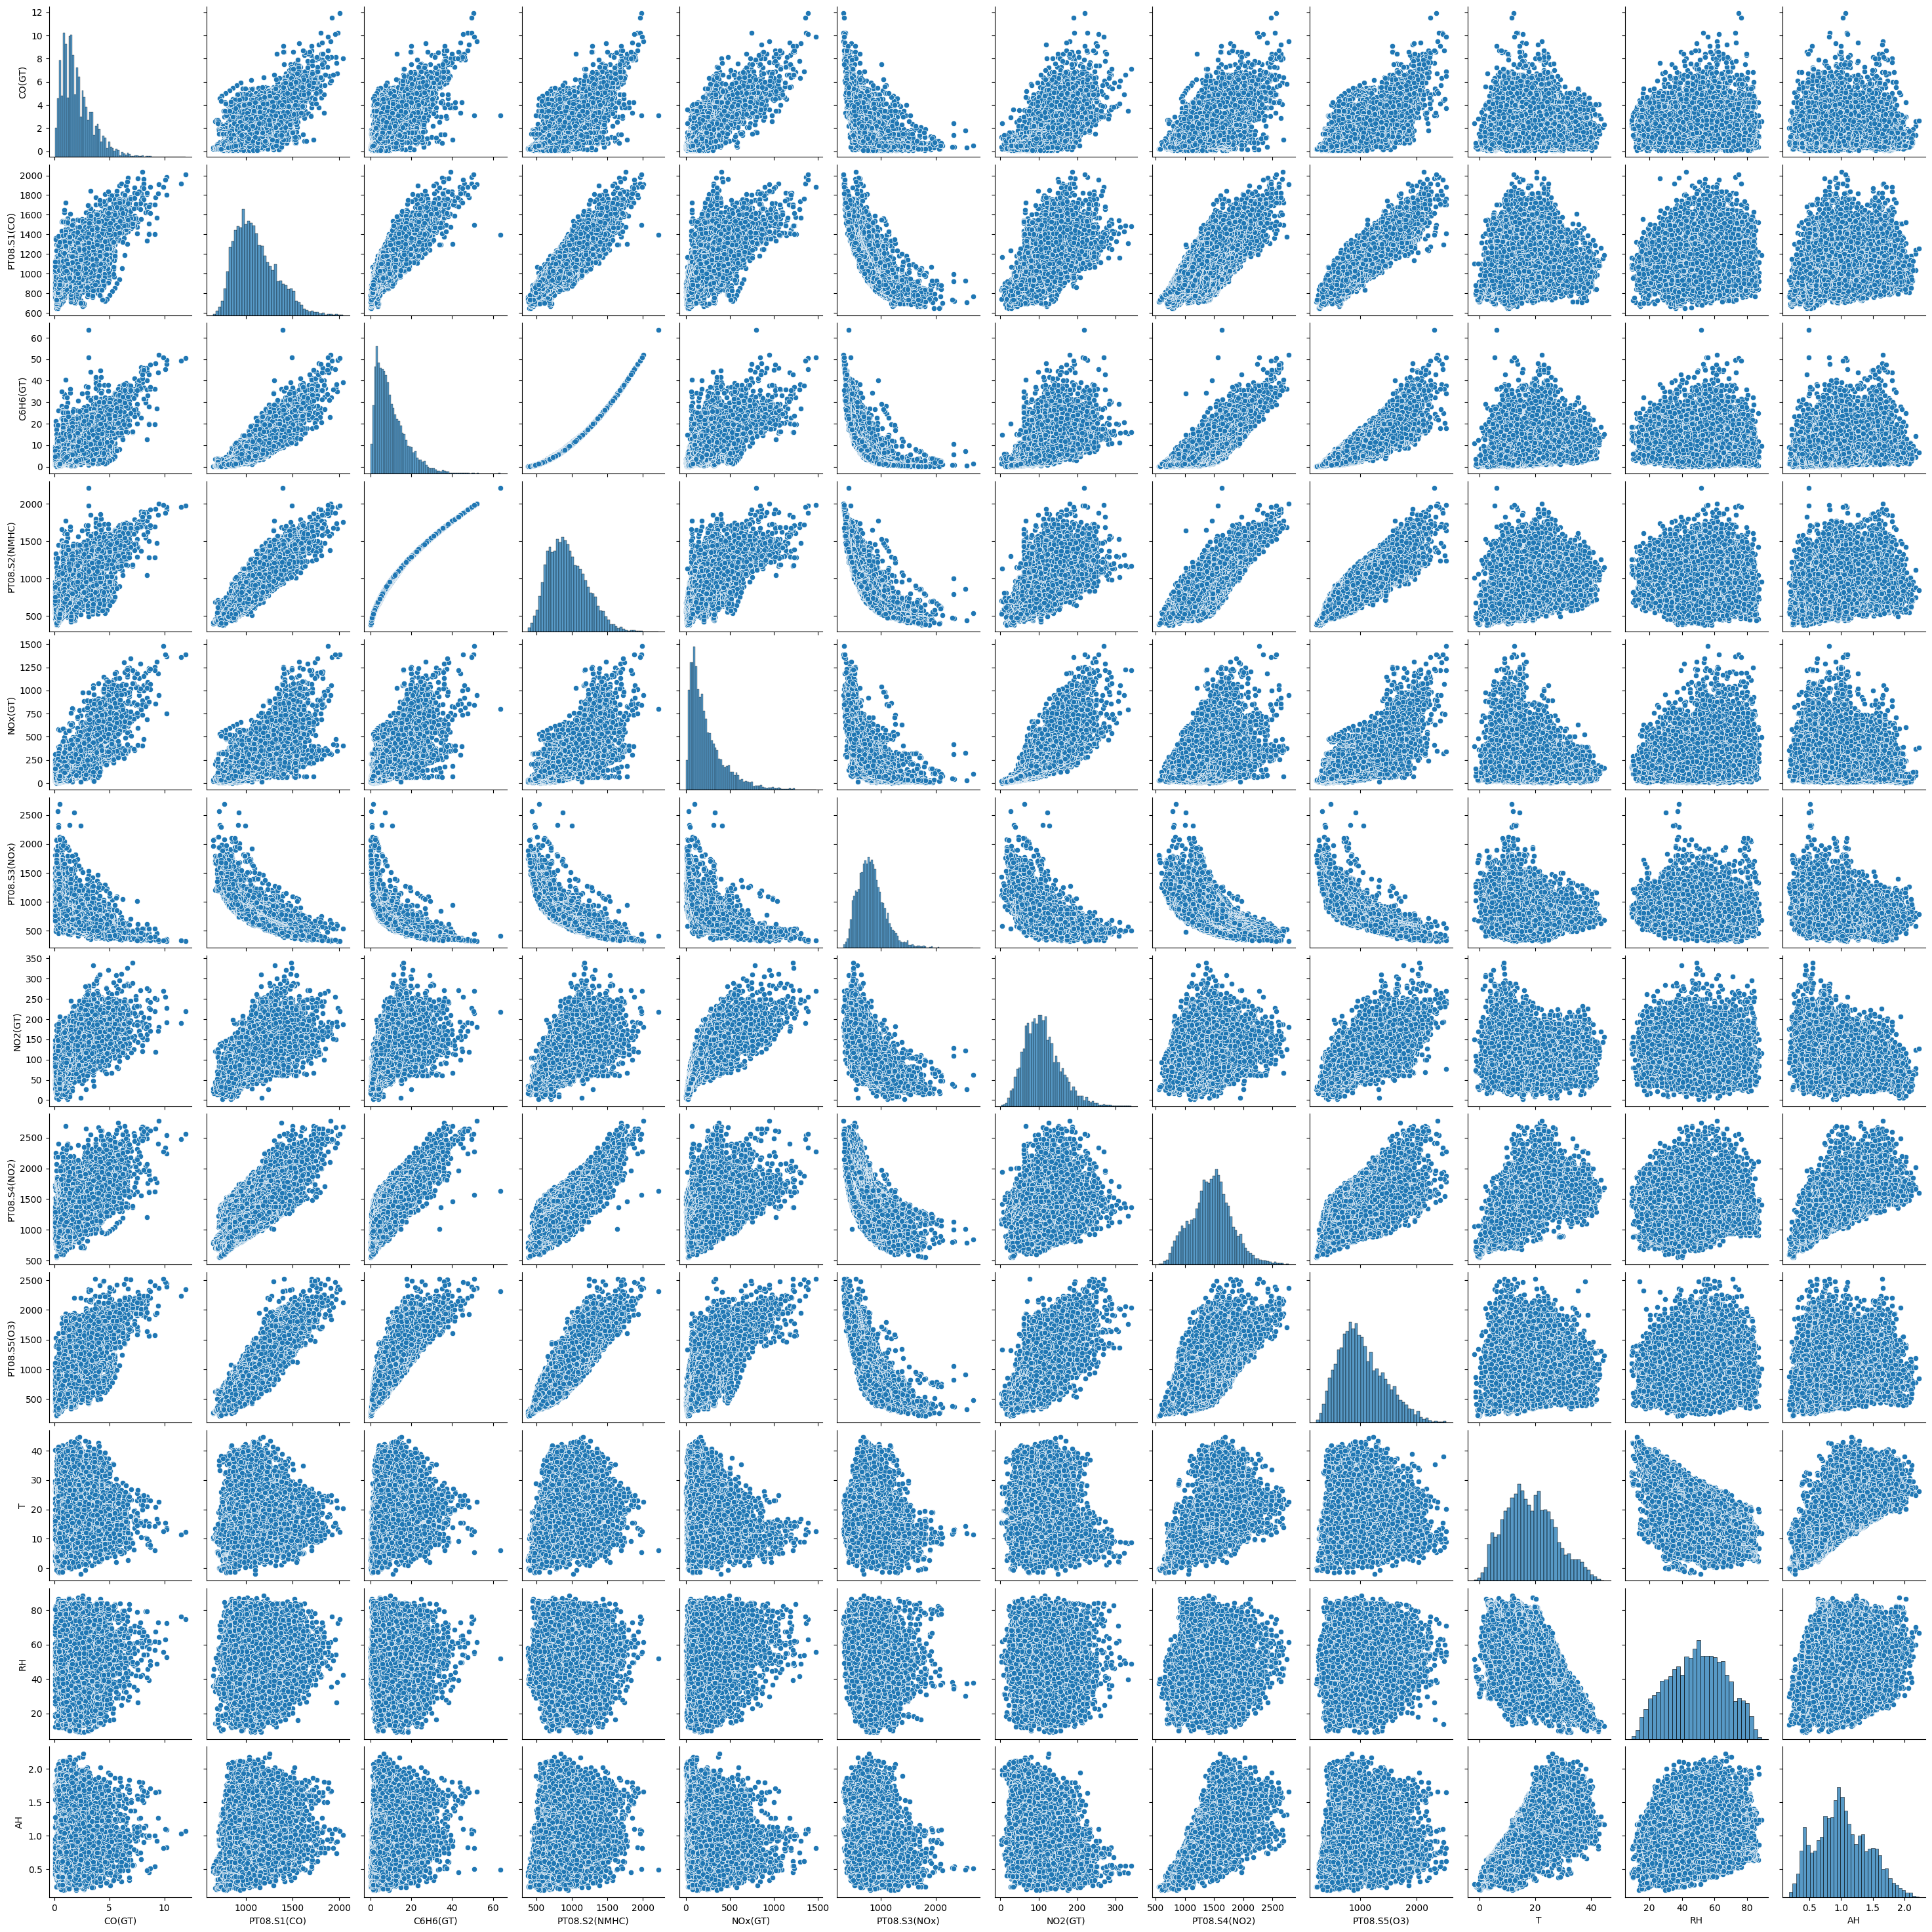

In [13]:
#DATA VISUALIZATION
import seaborn as sns
import matplotlib.pyplot as plt
sns.pairplot(data=df)

In [ ]:
df.head()

# CALCULATE AIR QUALITY INDEX FOR CO(GT) BASED ON FORMULA
The air quality index is a piecewise linear function of the pollutant concentration. At the boundary between AQI categories, there is a discontinuous jump of one AQI unit. To convert from concentration to AQI this equation is used

Function to calculate co(GT) individual pollutant index(co)


Function to calculate CO(GT) individual pollutant index(COi)

In [ ]:
import numpy as np

import numpy as np

# CO(GT) - Carbon Monoxide
def cal_COi(CO):
    if CO < 0:
        return np.nan
    if CO <= 1.0:
        return CO * (50 / 1.0)
    elif 1.0 < CO <= 2.0:
        return 50 + (CO - 1.0) * (50 / 1.0)
    elif 2.0 < CO <= 10.0:
        return 100 + (CO - 2.0) * (100 / 8.0)
    elif 10.0 < CO <= 17.0:
        return 200 + (CO - 10.0) * (100 / 7.0)
    elif 17.0 < CO <= 34.0:
        return 300 + (CO - 17.0) * (100 / 17.0)
    elif CO > 34.0:
        return 400 + (CO - 34.0) * (100 / 17.0)
    else:
        return np.nan

# Add the calculated COi column to the DataFrame df
df['COi'] = df['CO(GT)'].apply(cal_COi)

# Display the first few rows to verify
data = df[['CO(GT)', 'COi']] # Use the correct column names
data.head()
# calculating the individual pollutant index for C0

Function to calculate C6H6(GT)  individual pollutant index

In [ ]:
# Define the function to calculate C6H6 individual pollutant index
def cal_C6H6i(C6H6):
    if C6H6 < 0:
        return np.nan
    if C6H6 <= 5:
        C6H6_index = C6H6 * (50 / 5)
    elif 5 < C6H6 <= 10:
        C6H6_index = 50 + (C6H6 - 5) * (50 / 5)
    elif 10 < C6H6 <= 15:
        C6H6_index = 100 + (C6H6 - 10) * (100 / 5)
    elif 15 < C6H6 <= 20:
        C6H6_index = 200 + (C6H6 - 15) * (100 / 5)
    elif 20 < C6H6 <= 25:
        C6H6_index = 300 + (C6H6 - 20) * (100 / 5)
    elif C6H6 > 25:
        C6H6_index = 400 + (C6H6 - 25) * (100 / 5)
    else:
        C6H6_index = np.nan
    return C6H6_index

# Add the calculated C6H6i column to the DataFrame df
df['C6H6i'] = df['C6H6(GT)'].apply(cal_C6H6i)

# Create a subset DataFrame with the original and calculated index columns
data = df[['C6H6(GT)', 'C6H6i']]  # Use the correct column names

# Display the first few rows to verify
data.head()

Function to calculate NOx(GT)individual pollutant index

In [ ]:
def cal_NOxi(NOx):
    if NOx < 0:
        return np.nan
    if NOx <= 40:
        NOx_index = NOx * (50 / 40)
    elif 40 < NOx <= 80:
        NOx_index = 50 + (NOx - 40) * (50 / 40)
    elif 80 < NOx <= 180:
        NOx_index = 100 + (NOx - 80) * (100 / 100)
    elif 180 < NOx <= 280:
        NOx_index = 200 + (NOx - 180) * (100 / 100)
    elif 280 < NOx <= 400:
        NOx_index = 300 + (NOx - 280) * (100 / 120)
    elif NOx > 400:
        NOx_index = 400 + (NOx - 400) * (100 / 120)
    else:
        NOx_index = np.nan
    return NOx_index

# Add the calculated NOxi column to the DataFrame df
df['NOxi'] = df['NOx(GT)'].apply(cal_NOxi)

# Create a subset DataFrame with the original and calculated index columns
data = df[['NOx(GT)', 'NOxi']]  # Use the correct column names

# Display the first few rows to verify
data.head()

Function to calculate NOx(GT)individual pollutant index

In [ ]:
def cal_NO2i(NO2):
    if NO2 < 0:
        return np.nan
    if NO2 <= 40:
        NO2_index = NO2 * (50 / 40)
    elif 40 < NO2 <= 80:
        NO2_index = 50 + (NO2 - 40) * (50 / 40)
    elif 80 < NO2 <= 180:
        NO2_index = 100 + (NO2 - 80) * (100 / 100)
    elif 180 < NO2 <= 280:
        NO2_index = 200 + (NO2 - 180) * (100 / 100)
    elif 280 < NO2 <= 400:
        NO2_index = 300 + (NO2 - 280) * (100 / 120)
    elif NO2 > 400:
        NO2_index = 400 + (NO2 - 400) * (100 / 120)
    else:
        NO2_index = np.nan
    return NO2_index

# Add the calculated NO2i column to the DataFrame df
df['NO2i'] = df['NO2(GT)'].apply(cal_NO2i)

# Create a subset DataFrame with the original and calculated index columns
data = df[['NO2(GT)', 'NO2i']]  # Use the correct column names

# Display the first few rows to verify
data.head()

In [ ]:
def cal_aqi(COi,C6H6i,NOxi,NO2i):
    aqi=0
    if(COi>C6H6i and COi>NOxi and COi>NO2i ):
     aqi=COi
    if(C6H6i>COi and C6H6i>NOxi and C6H6i>NO2i ):
     aqi=C6H6i
    if(NOxi>COi and NOxi>C6H6i and NOxi>NO2i ):
     aqi=NOxi
    if(NO2i>COi and NO2i>C6H6i and NO2i>NOxi ):
     aqi=NO2i


    return aqi

df['AQI']=df.apply(lambda x:cal_aqi(x['COi'],x['C6H6i'],x['NOxi'],x['NO2i']),axis=1)
data= df[['COi','C6H6i','NOxi','NO2i','AQI']] # Fix: use double brackets to select multiple columns
data.head()
# Caluclating the Air Quality Index.

In [ ]:
# Using threshold values to classify a particular values as good, moderate, poor, unhealthy, very unhealthy and Hazardous
# Define the function to classify AQI into ranges
def AQI_Range(x):
    if x <= 50:
        return "Good"
    elif x > 50 and x <= 100:
        return "Moderate"
    elif x > 100 and x <= 200:
        return "Poor"
    elif x > 200 and x <= 300:
        return "Unhealthy"
    elif x > 300 and x <= 400:
        return "Very Unhealthy"
    elif x > 400:
        return "Hazardous"

# Apply the function to the 'AQI' column in the DataFrame
df['AQI_Range'] = df['AQI'].apply(AQI_Range)
df.head()



In [ ]:
df['AQI_Range'].value_counts()
# These are the counts of values present in the AQI_Range column.

Splitting the dataset into Dependent and Independent columns


In [ ]:
X=df[['COi','C6H6i','NOxi','NO2i']]
Y=df['AQI']
X.head()
# we only select columns like COi,C6H6i,NOxi,NO2i

In [ ]:
Y.head()
# the AQI column is the target column

In [ ]:
#Splitting data into training and testing data
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=42)
print(X_train.shape,X_test.shape,Y_train.shape,Y_test.shape)

In [ ]:
print("X_train shape:", X_train.shape)

### Linear Regression


In [ ]:
#Linear Regression
from sklearn.linear_model import LinearRegression
model=LinearRegression()
model.fit(X_train,Y_train)

In [ ]:
#predicting train
train_pred=model.predict(X_train)
#predicting on test
test_pred=model.predict(X_test)

In [ ]:
#Evaluation metrics
from sklearn import metrics
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
RMSE_train=(np.sqrt(metrics.mean_squared_error(Y_train,train_pred)))
RMSE_test=(np.sqrt(metrics.mean_squared_error(Y_test,test_pred)))
print("RMSE TrainingData = ",str(RMSE_train))
print("RMSE TestData = ",str(RMSE_test))
print('-'*50)
print('RSquared value on train:',model.score(X_train, Y_train))
print('RSquared value on test:',model.score(X_test, Y_test))

### Random Forest Classifier

In [ ]:
#fit the model on train data
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
RF=RandomForestRegressor(random_state=42).fit(X_train,Y_train)
#predict on train
train_preds4 = RF.predict(X_train)
#evaluate train
print("RMSE TrainingData = ",str(np.sqrt(mean_squared_error(Y_train,train_preds4))))
print('RSquared value on train:',r2_score(Y_train,train_preds4))
print('-'*50)

#predict on test
test_preds4 = RF.predict(X_test)
#evaluate on test
print("RMSE TestData = ",str(np.sqrt(mean_squared_error(Y_test,test_preds4))))
print('RSquared value on test:',r2_score(Y_test,test_preds4))

### Classification Algorithms

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
X2 = df[['COi','C6H6i','NOxi','NO2i']]
Y2 = df['AQI_Range']
# Splitting the data into independent and dependent columns for classification

In [ ]:
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X2, Y2, test_size=0.33, random_state=70)
# Splitting the data into training and testing data

Logistic Regression

In [ ]:
#fit the model on train data
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import accuracy_score, mean_absolute_error,mean_squared_error,r2_score, cohen_kappa_score
import numpy as np

#fit the model on train data
log_reg = LogisticRegression().fit(X_train2, Y_train2)

#predict on train
train_preds2 = log_reg.predict(X_train2)
#accuracy on train
print("Model accuracy on train is: ", accuracy_score(Y_train2, train_preds2))

#predict on test
test_preds2 = log_reg.predict(X_test2)
#accuracy on test
print("Model accuracy on test is: ", accuracy_score(Y_test2, test_preds2))
print('-'*50)

# Kappa Score.
print('KappaScore is: ', metrics.cohen_kappa_score(Y_test2,test_preds2))

In [ ]:
log_reg.predict([[1, 1.2, 3.12, 0]]) # Added 2 placeholder features (0, 1)

K-Nearest Neighbours

In [ ]:
#fit the model on train data
KNN = KNeighborsClassifier().fit(X_train2,Y_train2)
#predict on train
train_preds5 = KNN.predict(X_train2)
#accuracy on train
print("Model accuracy on train is: ", accuracy_score(Y_train2, train_preds5))

#predict on test
test_preds5 = KNN.predict(X_test2)
#accuracy on test
print("Model accuracy on test is: ", accuracy_score(Y_test2, test_preds5))
print('-'*50)

# Kappa Score
print('KappaScore is: ', metrics.cohen_kappa_score(Y_test2,test_preds5))

In [ ]:
KNN.predict([[7.4,47.7,78.182,100]])
# Predictions on random values

In [ ]:
KNN.predict([[1,1.2,3.12,0]])
# Predictions on random values

In [ ]:
KNN.predict([[325.7,345,798.182,305]])
# Predictions on random values